<a href="https://colab.research.google.com/github/DerNiccoo/TheEarlyBird/blob/main/Aufgabe3/Nico/3_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
model_conv = torchvision.models.resnet18(pretrained=True)

for param in model_conv.parameters():
  param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
class CIFAR8(Dataset):
    """CIFAR8."""

    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse')

    def __init__(self, dataset):
      self.cifar8 = []
      for i in range(len(dataset)):
        if dataset.targets[i] in [0, 1, 2, 3, 4, 5, 6, 7]:
          self.cifar8.append(dataset[i])

      print(len(self.cifar8))

    def __len__(self):
        return len(self.cifar8)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        items = self.cifar8[idx]
        return items

In [5]:
print(trainset[0])

(tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
         [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
         [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
         ...,
         [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
         [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
         [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],

        [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
         [-0.8431, -1.0000, -0.9373,  ..., -0.3098, -0.3490, -0.3176],
         [-0.8118, -0.9451, -0.7882,  ..., -0.3412, -0.3412, -0.4275],
         ...,
         [ 0.3333,  0.2000,  0.2627,  ...,  0.0431, -0.7569, -0.7333],
         [ 0.0902, -0.0353,  0.1294,  ...,  0.1608, -0.5137, -0.5843],
         [ 0.1294,  0.0118,  0.1137,  ...,  0.4431, -0.0745, -0.2784]],

        [[-0.5059, -0.6471, -0.6627,  ..., -0.1529, -0.2000, -0.1922],
         [-0.8431, -1.0000, -1.0000,  ..., -

In [6]:
train_set = CIFAR8(dataset=trainset)
test_set = CIFAR8(dataset=testset)

40000
8000


In [7]:
classes = CIFAR8.classes

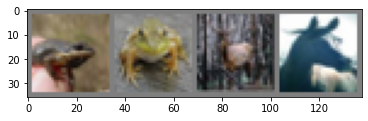

 frog  frog  deer horse


In [8]:
trainloader = torch.utils.data.DataLoader(train_set, batch_size=4,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))


            running_loss = 0.0

print('Finished Training')

[1,  1000] loss: 2.078
[1,  2000] loss: 2.013
[1,  3000] loss: 1.856
[1,  4000] loss: 1.706
[1,  5000] loss: 1.627
[1,  6000] loss: 1.549
[1,  7000] loss: 1.469
[1,  8000] loss: 1.398
[1,  9000] loss: 1.410
[1, 10000] loss: 1.371
[2,  1000] loss: 1.328
[2,  2000] loss: 1.335
[2,  3000] loss: 1.309
[2,  4000] loss: 1.279
[2,  5000] loss: 1.256
[2,  6000] loss: 1.230
[2,  7000] loss: 1.235
[2,  8000] loss: 1.222
[2,  9000] loss: 1.253
[2, 10000] loss: 1.213
Finished Training


In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [12]:
model_save_name = 'cifar8.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(net.state_dict(), path)